In [2]:
import subprocess
import os
import sys
import pyhmmer
from pyhmmer import hmmscan as hmmscan
import pandas as pd
import multiprocessing.pool
import math
import re
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
input_dir = "/Users/u241374/mike_tisza/sandbox/human_split_proteins"

out_dir = "/Users/u241374/mike_tisza/sandbox/pyhmmer_tests/out_human"

which_DB = "/Users/u241374/mike_tisza/cmmr_repos/Cenote-Taker3/hmmscan_DBs/virus_specific_baits_plus_missed6a"

CPUcount = 12

evalue_cut = 0.1

evalue_cut = float(evalue_cut)

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
def hmmscanner(seqs):
    scanout = list(hmmscan(pyhmmer.easel.SequenceFile(seqs, digital=True), pyhmmer.plan7.HMMFile(which_DB)))
    return scanout

In [5]:
splitAA_list = []
for splitAA in os.listdir(input_dir):
    if splitAA.endswith('.faa'):
        f = os.path.join(input_dir, splitAA)

        if os.path.isfile(f) and os.path.getsize(f) > 0:
            splitAA_list.append(f)

if not splitAA_list:
    print("no files found for pyhmmer in " + str(input_dir))
    exit

In [6]:
hmm_lengths = {}
with pyhmmer.plan7.HMMFile(which_DB) as hmm_file:
    for hmm in hmm_file:
        hmm_lengths[hmm.name.decode()] = len(hmm.consensus)

In [7]:
hmmscan_list = []
with multiprocessing.pool.ThreadPool(int(CPUcount)) as pool:
    for alignments in pool.map(hmmscanner, splitAA_list):
        for model in alignments:
            quer1 = model.query_name.decode()
            pos = quer1.rfind("_")
            contig = quer1[:pos]
            for hit in model:
                target_name = hit.name.decode()
                target_acc = hit.accession
                full_seq_evalue = hit.evalue
                seq_pvalue = hit.pvalue      
                n_aligned_positions = len(
                    hit.best_domain.alignment.hmm_sequence
                ) - hit.best_domain.alignment.hmm_sequence.count(".")
                hmm_coverage = (
                    n_aligned_positions / hmm_lengths[hit.best_domain.alignment.hmm_name.decode()]
                )
                
                hmmscan_list.append([quer1, contig, target_name, full_seq_evalue, seq_pvalue, 
                                     n_aligned_positions, hmm_coverage])

hmmscan_pools_df = pd.DataFrame(hmmscan_list, columns=["ORFquery", "contig", "target", "evalue", 
                                                       "pvalue", "n_aligned_positions", "hmm_coverage"])\
    .sort_values('evalue').drop_duplicates('ORFquery').query("evalue <= @evalue_cut")

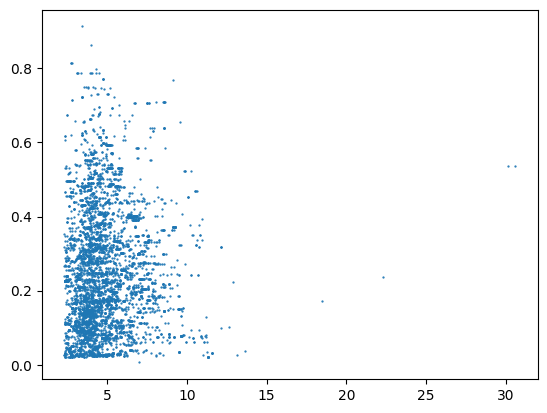

In [14]:
checkp = plt.plot(-np.log(hmmscan_pools_df['evalue']), hmmscan_pools_df['hmm_coverage'], 'o', ms=0.6)

print(checkp)

In [13]:
hmmscan_pools_df.query("hmm_coverage > 0.75 & evalue < 1e-3")

,ORFquery,contig,target,evalue,pvalue,n_aligned_positions,hmm_coverage
2872,NP_057143.1,NP,ne1_singleton18/Uniprot:A0A0G3GTX8_9CORY-type-...,0.000112,3.891640e-08,80,0.769231


In [15]:
hmmscan_pools_df.query("evalue < 1e-8")


,ORFquery,contig,target,evalue,pvalue,n_aligned_positions,hmm_coverage
6297,NP_001337858.1,NP,unclassified_RNA_cluster.32/PDB:3J06_A-Coat-pr...,5.197243e-14,1.802720e-17,29,0.537037
13117,NP_612429.2,NP,unclassified_RNA_cluster.32/PDB:3J06_A-Coat-pr...,8.020939e-14,2.782150e-17,29,0.537037
789,NP_008941.3,NP,podo_cluster.8/PDB:4BIJ_C-Terminase-large-subunit,2.113279e-10,7.330139e-14,156,0.237805
10697,NP_001278405.1,NP,podo_cluster.8/PDB:4BIJ_C-Terminase-large-subunit,9.721362e-09,3.371960e-12,112,0.170732
